# 04 - 3DGS Slice Interpolation Training

Core experiment: train 3D Gaussian Splatting model for CT slice interpolation.

Process:
1. For each volume: initialize Gaussians -> optimize -> render interpolated slices
2. Evaluate on test set with R=2 and R=3
3. Compare with baselines

In [1]:
# Mount Drive and setup
from google.colab import drive
drive.mount('/content/drive')

!pip install nibabel SimpleITK scikit-image PyYAML tqdm seaborn tensorboard -q

import sys, os
PROJECT_ROOT = "/content/drive/MyDrive/TLCN"
sys.path.insert(0, PROJECT_ROOT)

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 44.8 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
from tqdm import tqdm
import json
import time

# Verify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    vram = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {gpu_name} ({vram:.1f} GB VRAM)")
else:
    print("WARNING: No GPU available! Training will be very slow.")

GPU: NVIDIA L4 (23.7 GB VRAM)


In [3]:
from src.utils.config import load_config
from src.utils.seed import set_seed
from src.data.ct_org_loader import CTORGLoader
from src.data.sparse_simulator import SparseSimulator
from src.training.trainer_3dgs import Trainer3DGS
from src.evaluation.metrics import evaluate_volume
from src.evaluation.visualization import plot_training_curves

config = load_config(os.path.join(PROJECT_ROOT, "configs/default.yaml"))
set_seed(config["training"]["seed"])

OUTPUT_DIR = os.path.join(config["data"]["output_root"], "3dgs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load data
loader = CTORGLoader(
    dataset_root=config["data"]["dataset_root"],
    hu_min=config["data"]["hu_min"],
    hu_max=config["data"]["hu_max"],
)
available_cases = loader.get_available_cases()
split = CTORGLoader.get_split(
    available_cases,
    config["data"]["test_cases"],
    config["data"]["val_cases"],
)

print(f"Train: {len(split['train'])}, Val: {len(split['val'])}, Test: {len(split['test'])}")

Train: 98, Val: 21, Test: 21


In [ ]:
# Quick validation on a single volume first
print("="*60)
print("Quick validation run on 1 volume")
print("="*60)

sample_case = split["val"][0]
volume, labels, metadata = loader.load_and_preprocess(sample_case)
print(f"Volume {sample_case}: shape={volume.shape}")

R = 2
simulator = SparseSimulator(sparse_ratio=R)
sparse_data = simulator.simulate(volume)

# Create a quick-train config (fewer iterations)
quick_config = config.copy()
quick_config["gaussian"] = config["gaussian"].copy()
quick_config["gaussian"]["num_iterations"] = 500
quick_config["gaussian"]["densify_interval"] = 100

# Train on this volume
trainer = Trainer3DGS(
    volume=volume,
    observed_indices=sparse_data["observed_indices"],
    target_indices=sparse_data["target_indices"],
    config=quick_config,
    labels=labels,
    device=device,
    checkpoint_dir=os.path.join(OUTPUT_DIR, f"quick_val_case{sample_case}"),
)

history = trainer.train()

Quick validation run on 1 volume
Volume 21: shape=(512, 512, 826)


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.mixed_precision)


Starting 3DGS training: 6766592 Gaussians, 413 observed slices, volume shape (512, 512, 826)


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):


Iter 0/500 | Loss: 0.046032 | Rec: 0.045725 | PSNR: 25.19 dB | #GS: 6766592 | Time: 6.5s


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarn

Iter 200/500 | Loss: 0.097843 | Rec: 0.097399 | PSNR: 24.24 dB | #GS: 6766592 | Time: 715.6s


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarn

Iter 400/500 | Loss: 0.106594 | Rec: 0.106153 | PSNR: 25.66 dB | #GS: 6766592 | Time: 1428.3s
Training complete in 1779.3s. Final #Gaussians: 6766592



Quick validation results (case 21, R=2):
  PSNR: 25.17 +/- 2.58 dB
  SSIM: 0.6387 +/- 0.0974


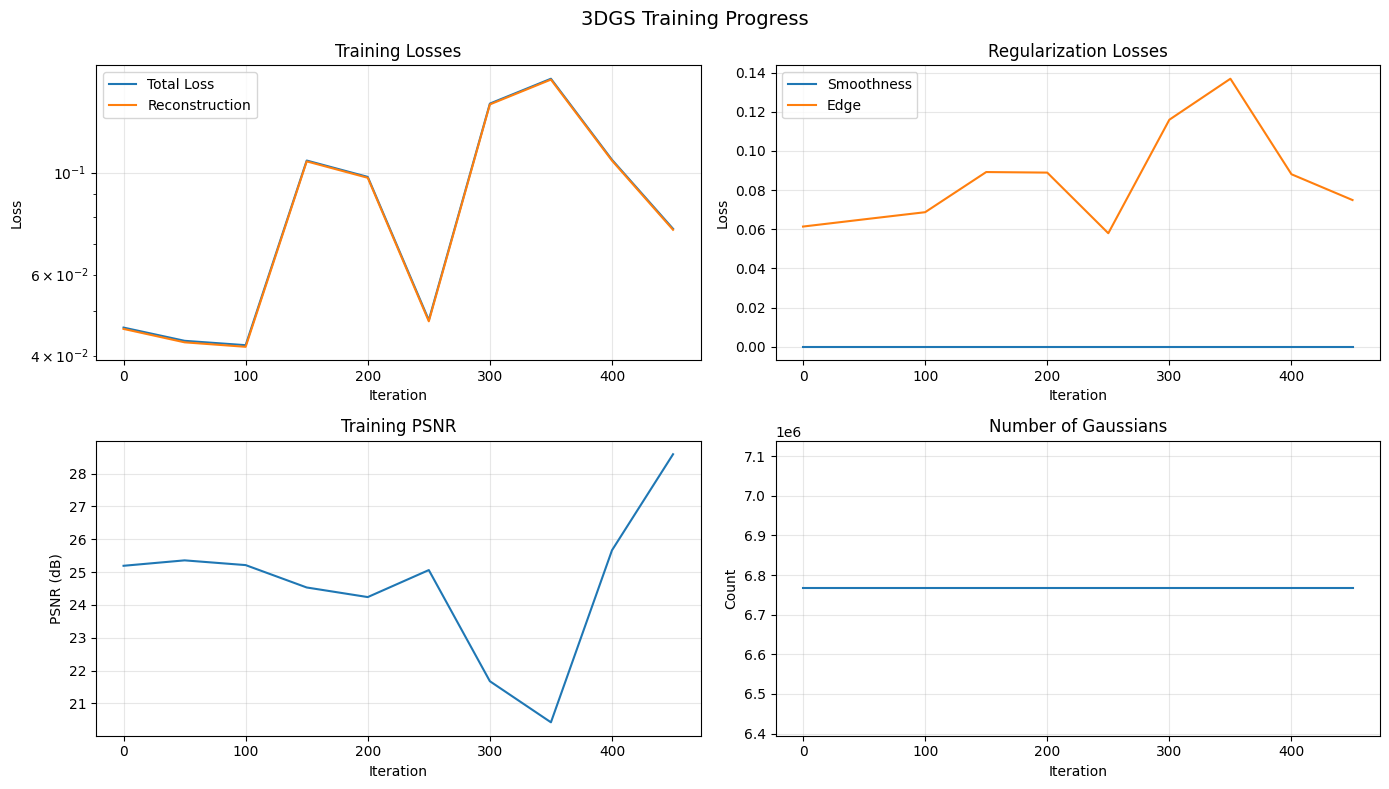

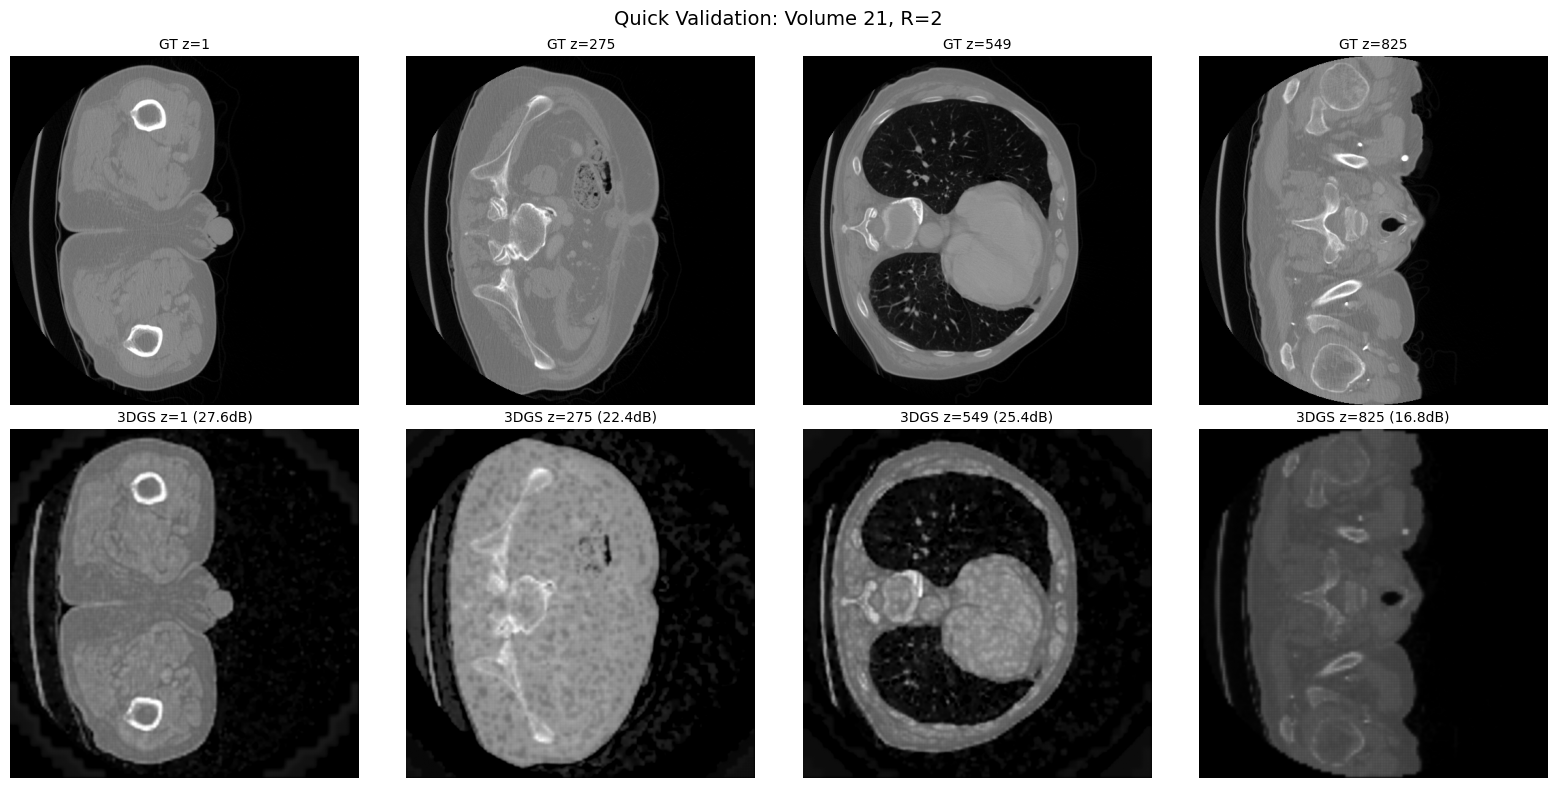

In [ ]:
# Evaluate quick validation
import matplotlib.pyplot as plt

eval_result = trainer.evaluate_on_targets()
print(f"\nQuick validation results (case {sample_case}, R={R}):")
print(f"  PSNR: {eval_result['summary']['mean_psnr']:.2f} +/- "
      f"{eval_result['summary']['std_psnr']:.2f} dB")
print(f"  SSIM: {eval_result['summary']['mean_ssim']:.4f} +/- "
      f"{eval_result['summary']['std_ssim']:.4f}")

# Plot training curves
fig = plot_training_curves(
    history,
    save_path=os.path.join(OUTPUT_DIR, f"quick_val_training_curves.png"),
)
plt.show()

# Visualize some interpolated slices
predictions = trainer.render_interpolated_slices()

# Show 4 sample interpolated slices
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
sample_indices = np.linspace(0, len(sparse_data["target_indices"]) - 1, 4, dtype=int)

for i, idx in enumerate(sample_indices):
    z = sparse_data["target_indices"][idx]
    gt = volume[:, :, z]
    pred = predictions[:, :, idx]

    axes[0, i].imshow(gt, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'GT z={z}', fontsize=10)
    axes[0, i].axis('off')

    axes[1, i].imshow(pred, cmap='gray', vmin=0, vmax=1)
    from src.evaluation.metrics import compute_psnr
    psnr = compute_psnr(pred, gt)
    axes[1, i].set_title(f'3DGS z={z} ({psnr:.1f}dB)', fontsize=10)
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Ground Truth', fontsize=12)
axes[1, 0].set_ylabel('3DGS Prediction', fontsize=12)
plt.suptitle(f'Quick Validation: Volume {sample_case}, R={R}', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "quick_val_slices.png"), dpi=150)
plt.show()

# Free GPU memory
del trainer
torch.cuda.empty_cache()

In [4]:
# Full training on test set volumes
print("="*60)
print("Full 3DGS Training on Test Set")
print("="*60)

all_results = {}

for R in config["data"]["sparse_ratios"]:
    key = f"3dgs_R{R}"
    all_results[key] = {}
    simulator = SparseSimulator(sparse_ratio=R)
    psnr_list = []
    ssim_list = []

    print(f"\n--- Sparse Ratio R={R} ---")

    for case_idx in split["test"]:
        t0 = time.time()
        print(f"\nProcessing case {case_idx}...")

        try:
            volume, labels, metadata = loader.load_and_preprocess(case_idx)
            sparse_data = simulator.simulate(volume)

            print(f"  Volume shape: {volume.shape}, "
                  f"Observed: {len(sparse_data['observed_indices'])}, "
                  f"Targets: {len(sparse_data['target_indices'])}")

            # Create trainer
            trainer = Trainer3DGS(
                volume=volume,
                observed_indices=sparse_data["observed_indices"],
                target_indices=sparse_data["target_indices"],
                config=config,
                labels=labels,
                device=device,
                checkpoint_dir=os.path.join(
                    OUTPUT_DIR, f"R{R}", f"case_{case_idx}"
                ),
            )

            # Train
            history = trainer.train()

            # Evaluate
            eval_result = trainer.evaluate_on_targets()
            all_results[key][case_idx] = eval_result["summary"]
            psnr_list.append(eval_result["summary"]["mean_psnr"])
            ssim_list.append(eval_result["summary"]["mean_ssim"])

            elapsed = time.time() - t0
            print(f"  Case {case_idx} done in {elapsed:.1f}s: "
                  f"PSNR={eval_result['summary']['mean_psnr']:.2f} dB, "
                  f"SSIM={eval_result['summary']['mean_ssim']:.4f}")

            # Free memory
            del trainer
            torch.cuda.empty_cache()

        except Exception as e:
            print(f"  ERROR on case {case_idx}: {e}")
            import traceback
            traceback.print_exc()
            torch.cuda.empty_cache()

    avg_psnr = np.mean(psnr_list) if psnr_list else 0
    avg_ssim = np.mean(ssim_list) if ssim_list else 0
    print(f"\n  Overall R={R}: PSNR={avg_psnr:.2f} dB, SSIM={avg_ssim:.4f}")

Full 3DGS Training on Test Set

--- Sparse Ratio R=2 ---

Processing case 0...
  Volume shape: (512, 512, 75), Observed: 38, Targets: 37


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.mixed_precision)


Starting 3DGS training: 622592 Gaussians, 38 observed slices, volume shape (512, 512, 75)


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):


Iter 0/2000 | Loss: 0.039999 | Rec: 0.039736 | PSNR: 25.38 dB | #GS: 622592 | Time: 6.3s
Iter 200/2000 | Loss: 0.056191 | Rec: 0.055888 | PSNR: 30.30 dB | #GS: 622592 | Time: 709.3s
Iter 400/2000 | Loss: 0.053323 | Rec: 0.053043 | PSNR: 31.11 dB | #GS: 622592 | Time: 1411.8s
Iter 600/2000 | Loss: 0.069548 | Rec: 0.069210 | PSNR: 28.39 dB | #GS: 622592 | Time: 2112.8s
Iter 800/2000 | Loss: 0.010301 | Rec: 0.010178 | PSNR: 39.38 dB | #GS: 622592 | Time: 2810.7s
Iter 1000/2000 | Loss: 0.019662 | Rec: 0.019488 | PSNR: 36.46 dB | #GS: 622592 | Time: 3510.2s
Iter 1200/2000 | Loss: 0.060952 | Rec: 0.060634 | PSNR: 27.83 dB | #GS: 622592 | Time: 4208.6s
Iter 1400/2000 | Loss: 0.015317 | Rec: 0.015151 | PSNR: 37.10 dB | #GS: 622592 | Time: 4905.3s
Iter 1600/2000 | Loss: 0.006566 | Rec: 0.006443 | PSNR: 38.24 dB | #GS: 622592 | Time: 5600.8s
Iter 1800/2000 | Loss: 0.019500 | Rec: 0.019326 | PSNR: 33.81 dB | #GS: 622592 | Time: 6296.0s
Training complete in 6988.5s. Final #Gaussians: 622592
  Case

/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.mixed_precision)
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):


Iter 0/2000 | Loss: 0.040682 | Rec: 0.040370 | PSNR: 25.45 dB | #GS: 1015808 | Time: 3.5s
Iter 200/2000 | Loss: 0.072205 | Rec: 0.071844 | PSNR: 28.29 dB | #GS: 1015808 | Time: 705.9s
Iter 400/2000 | Loss: 0.049153 | Rec: 0.048864 | PSNR: 31.77 dB | #GS: 1015808 | Time: 1410.4s
Iter 600/2000 | Loss: 0.056021 | Rec: 0.055678 | PSNR: 30.71 dB | #GS: 1015808 | Time: 2114.2s
Iter 800/2000 | Loss: 0.066223 | Rec: 0.065753 | PSNR: 28.67 dB | #GS: 1015808 | Time: 2816.5s
Iter 1000/2000 | Loss: 0.064459 | Rec: 0.064050 | PSNR: 29.54 dB | #GS: 1015808 | Time: 3516.3s
Iter 1200/2000 | Loss: 0.072335 | Rec: 0.071938 | PSNR: 28.04 dB | #GS: 1015808 | Time: 4212.8s
Iter 1400/2000 | Loss: 0.026950 | Rec: 0.026737 | PSNR: 34.87 dB | #GS: 1015808 | Time: 4907.9s
Iter 1600/2000 | Loss: 0.078483 | Rec: 0.078121 | PSNR: 27.44 dB | #GS: 1015808 | Time: 5603.5s
Iter 1800/2000 | Loss: 0.028714 | Rec: 0.028513 | PSNR: 32.81 dB | #GS: 1015808 | Time: 6300.1s
Training complete in 6992.2s. Final #Gaussians: 101

/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:101: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.mixed_precision)
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):


Starting 3DGS training: 4243456 Gaussians, 259 observed slices, volume shape (512, 512, 517)
Iter 0/2000 | Loss: 0.065843 | Rec: 0.065404 | PSNR: 23.66 dB | #GS: 4243456 | Time: 3.5s


/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.mixed_precision):
/content/drive/MyDrive/TLCN/src/training/trainer_3dgs.py:208: FutureWarn

Iter 200/2000 | Loss: 0.065171 | Rec: 0.064619 | PSNR: 26.58 dB | #GS: 4243456 | Time: 708.4s


KeyboardInterrupt: 

In [5]:
# Save results
def convert_to_serializable(obj):
    if isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    return obj

with open(os.path.join(OUTPUT_DIR, "3dgs_results.json"), "w") as f:
    json.dump(convert_to_serializable(all_results), f, indent=2)

print(f"\nResults saved to {OUTPUT_DIR}")
print("3DGS training and evaluation complete!")


Results saved to /content/drive/MyDrive/TLCN/outputs/3dgs
3DGS training and evaluation complete!
